# Fiabilité et propagation d'incertitude

# 0) Import des bibliothèques Python

In [1]:
!pip install openturns 
!pip install SMT

In [2]:
import numpy as np
import scipy as sci
import openturns as ot
import scipy.stats as stat
import scipy.optimize as opt
import time as t #utile pour mesurer le temps d'execution des fonctions
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG
%matplotlib inline

# 1) Description du problème
## 1-1) Introduction

On souhaite étudier la fiabilité d'une passerelle soumise à un chargement réparti sur son tablier. Pour cela, la passerelle est modélisée par une poutre de longueur $L$, encastrée à son extrémité gauche et en appui simple à son extrémité droite, le chargement est noté $Q(l)$. La passerelle est de section rectangulaire de base $b$ et de hauteur $h$. Le module d'élasticité du matériau servant à la construction de la passerelle est $E$. La défaillance est caractérisée par un déplacement maximal autorisé noté $u_{max}$. 

La résolution de l'équation de la statique permettant de trouver le déplacement de la passerelle est effectuée par la méthode des éléments finis.


## 1-2) Résolution par la méthode des éléments finis

Le nombre d'éléments est noté $n_{elem}$. On suppose que le chargement réparti est vertical et compte $n_{nodes}=n_{elem}+1$ composantes notées $Q_i,~i=1,\cdots,n_{nodes}$. Le code suivant crée la fonction Python qui résout l'équation de la statique par la méthode des éléments finis et renvoie le déplacement max de la structure. Pour cela $n_{elem}$ éléments de poutre à 2 degrés de liberté par noeud sont utilisés.

In [3]:
def u_structure(n_elem,L,E,I,Q):
    
        #matrice de rigidité totale
        K = np.zeros((2*(n_elem+1),2*(n_elem+1)))
        #Longeur des éléments
        l = L/n_elem
        #boucle sur les éléments
        for i in range(n_elem):
            #matrice élémentaire
            K_elem = E*I/l**3*np.array([[12.0,6.0*l,-12.0,6.0*l],\
                                        [6.0*l,4.0*l**2,-6.0*l,2.0*l**2],\
                                       [-12.0,-6.0*l,12.0,-6.0*l],\
                                       [6*l,2.0*l**2,-6.0*l,4.0*l**2]])
            #Assemblage
            K[2*i:2*(i+1),2*i:2*(i+1)] = K[2*i:2*(i+1),2*i:2*(i+1)] + K_elem[0:2,0:2]
            K[2*(i+1):2*(i+2),2*i:2*(i+1)] = K[2*(i+1):2*(i+2),2*i:2*(i+1)] + K_elem[2:4,0:2]
            K[2*i:2*(i+1),2*(i+1):2*(i+2)] = K[2*i:2*(i+1),2*(i+1):2*(i+2)] + K_elem[0:2,2:4]
            K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] = K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] + K_elem[2:4,2:4]
            #conditions aux limites
        #encastrement en l = 0
        K[0:2,:] = 0.0
        K[:,0:2] = 0.0
        K[0,0] = 1.0
        K[1,1] = 1.0
        #appui simple en l = L
        K[-2,:] = 0.0
        K[:,-2] = 0.0
        K[-2,-2] = 1.0
        #Decomposition de Cholesky 
        K_fact = sci.linalg.cho_factor(K)
        #Second membre
        F = np.zeros((2*(n_elem+1),))
        F[0:-1:2] = Q    
        F[0:2] = 0.0
        F[-2] = 0.0
        #resolution du système KU = F
        U = sci.linalg.cho_solve(K_fact,F)    
        return U

def interpolation_EF(X,U,L):
    n_elem = len(U)/2-1
    l = L/n_elem
    U_X = np.zeros(X.shape)
    i = 0
    for x in X:
        #on cherche à quel élément appartient x et quelle est sa position relative
        n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche 
        #pour ne pas avoir de problème en x=L qui donnerait n=en_elem +1 et qui poserait problème
        s = (x-(n*l))/l
        #On recupère U_i et U_j correspondant
        u_i = U[2*n]
        theta_i = U[2*n+1]
        u_j = U[2*(n+1)]
        theta_j = U[2*(n+1)+1]
        u_x = u_i*(1.0-3.0*s**2+2.0*s**3)+u_j*(3.0*s**2-2.0*s**3)\
        +theta_i*(l*(s-2.0*s**2+s**3))+theta_j*(l*(-s**2+s**3))
        U_X[i] = u_x
        i = i+1   
    return U_X    

def find_max_dep(n_elem,L,E,I,Q):
    #On commence par résoudre le problème discrétisé
    U = u_structure(n_elem,L,E,I,Q)
    #Puis on cherche le min du problème continu grace à la fonction d'interpolation
    res_opt = opt.minimize(interpolation_EF,np.array([L/2.0]),method = "SLSQP", bounds=[[0.0,L]],args=(U,L),tol=1e-12)
    u_max = res_opt['fun']
    l_max = res_opt['x']
    return l_max,u_max,U    

<div class="alert alert-danger "><b>  Dans la suite on fixera $L=10.0$, $b=1.0$, $h=0.1$, $E =12e^9$, $Q_{total} = -3000$, $n_{elem}=50$ </b></div>

# 2) Propagation d'incertitude et fiabilité

On suppose à présent que les variables $b$ et $E$ sont aléatoires. L'objectif est de modéliser ces variables incertaines et de résoudre un problème de fiabilité par une méthode d'apprentissage actif. 

## 2-1) Modèle probabiliste des variables $b$ et $E$

Dans la suite on suppose que le code EF ci dessus donne la **valeur exacte** du déplacement maximal de la passerelle.
Dans cet exercice nous allons considérer que les paramètres $E$ et $b$ sont des variables aléatoires indépendantes telles que :
- $E$ suit une loi log-normale de moyenne $\mu_E=12e9$ et de coefficient de variation $10\%$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.LogNormal.html?highlight=lognormal. 

Remarque : $X$ de loi log-normale, $\mu_X= E[X]$, $\sigma_X=\sqrt{Var[X]}$, il existe une unique variable $Y$ de loi normale telle que $ln(X) = Y$ de moyenne $\mu_Y=\lambda_X$ et d'ecart type $\sigma_Y=\xi_X$ et nous avons
$$
\lambda_X = ln\left( \frac{\mu_X}{\sqrt{1+(\frac{\sigma_X}{\mu_X})^2}}\right)
$$
$$
\xi_X = \sqrt{ ln(1+(\frac{\sigma_X}{\mu_X})^2)}
$$

- $b$ suit une loi uniforme sur $[0.9,1.1]$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Uniform.html?highlight=uniform




<p class="bg-primary" style="padding:1em"> Le code ci dessous crée le modèle probabiliste des variables $E$ et $b$.</p>

In [4]:
mean_E = 12e9
cv_E = 0.1
Lambda_E = np.log(mean_E/(np.sqrt(1.+cv_E**2)))
Xi_E = np.sqrt(np.log(1.+cv_E**2))
Loi_E = ot.LogNormal(Lambda_E,Xi_E)
print ("mu_E =",Loi_E.getMean()[0],", cv_E=", Loi_E.getStandardDeviation()[0]/Loi_E.getMean()[0])
b_inf = 0.9
b_sup = 1.1
Loi_b = ot.Uniform(0.9,1.1)
print ("mu_b=",Loi_b.getMean()[0],", cv_b=", Loi_b.getStandardDeviation()[0]/Loi_b.getMean()[0])
input_distribution = ot.ComposedDistribution([Loi_E,Loi_b])

mu_E = 11999999999.999966 , cv_E= 0.10000000000000019
mu_b= 1.0 , cv_b= 0.0577350269189626


## 2.2) Approximation par processus gaussien
Dans cette partie nous allons utiliser l'approximation par processus gaussien pour créer une approximation de la fonction $U_{max}(E,b)$. Pour cela nous utiliserons la bibliothèque python SMT (https://smt.readthedocs.io/en/latest/). 

Afin de fixer les idées et d'apprendre à utliser la bibliothèque SMT nous commençons par l'approximation d'une fonction 1D, 

$$
f(x) = \frac{3}{2}x + \sin(x\pi)
$$
pour $x\in[0,2]$


Le code ci-dessous crée la fonction étudiée et trace son graphe.  

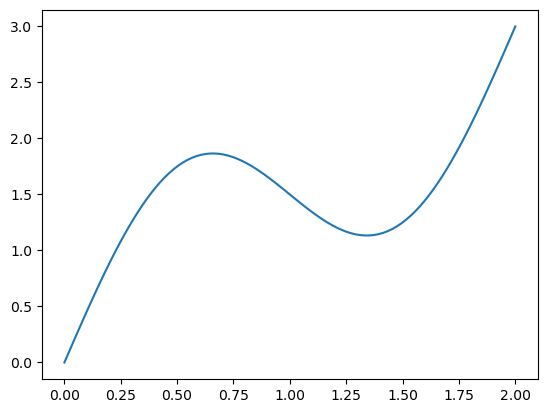

In [5]:
def f(x):
  y = 1.5*x+np.sin(x*np.pi)
  return y
X = np.linspace(0,2,100)
Y = f(X)
plt.figure()
plt.plot(X,Y)  

On suppose que $X$ suit une loi uniforme sur [0,2], nous allons maintenant créer le plan d'expériences (DoE) permettant de créer l'approximation par processus gaussien. 

Pour cela 2 méthodes vont être employées :
- le tirage aléatoire 
- et le tirage LHS (Latin Hypercube Sampling, http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.LHSExperiment.html?highlight=lhsexperiment)

<p class="bg-primary" style="padding:1em">**Question 1) : ** Compléter le code ci dessous afin de créer ces deux échantillons? Comparer les échantillons, qu'observez vous? (relancer plusieurs fois la création des échantillons)</p>  

In [ ]:
n_DoE = 4
X = ot.Uniform(0,2)
sample_X_random = X.#A compléter
LHS = ot.LHSExperiment(#A compléter,#A compléter)
sample_X_LHS = LHS.#A compléter
plt.figure()
plt.plot(sample_X_random,np.zeros(n_DoE),'r.',label='random')
plt.plot(sample_X_LHS,np.zeros(n_DoE),'b.',label='LHS')
plt.legend(loc=0)

<p class="bg-primary" style="padding:1em">**Question 2) : ** Compléter le code suivant afin d'évaluer la fonction aux points du DoE et de construire l'approximation par PG en utilisant un prior de moyenne constante et de noyau de corrélation exponentielle carrée.  Pour cela on utilisera l'aide https://smt.readthedocs.io/en/latest/_src_docs/surrogate_models/krg.html.     
Que fait la fonction train() ? </p>

In [ ]:
sample_Y_random = f(#A compléter)
sample_Y_LHS = f (#A compléter)
sm_random = KRG(poly = #A compléter, corr=#A compléter)   
sm_random.set_training_values(np.array(sample_X_random),np.array(sample_Y_random))
sm_random.train()
sm_LHS = KRG(poly = #A compléter, corr=#A compléter)   
sm_LHS.set_training_values(np.array(sample_X_LHS),np.array(sample_Y_LHS))
sm_LHS.train()

<p class="bg-primary" style="padding:1em">**Question 3) : ** Compléter le code suivant afin de calculer la moyenne du processus gaussien et un intervalle de confiance à +/- 3 écart types sur le domaine [0,2] ?</p>

In [ ]:
X = np.linspace(0,2,100).reshape((100,1))
mu_random = sm_random.#A compléter
mu_LHS = sm_LHS.#A compléter
variance_random =sm_random.#A compléter
variance_LHS = sm_LHS.#A compléter
plt.figure()
plt.plot(X,Y,'b',label = 'ref')
plt.plot(X,mu_random,'k',label = 'random sampling')
plt.plot(X,mu_LHS,'r',label = 'LHS sampling')
plt.legend(loc=0)
plt.figure()
plt.plot(X,Y,'b',label = 'ref')
plt.plot(X,mu_random,'k',label = 'random sampling')
plt.plot(X,mu_random+3.0*np.sqrt(variance_random),'k--')
plt.plot(X,mu_random-3.0*np.sqrt(variance_random),'k--')
plt.legend(loc=0)
plt.figure()
plt.plot(X,Y,'b',label = 'ref')
plt.plot(X,mu_LHS,'r',label = 'LHS sampling')
plt.plot(X,mu_LHS+3.0*np.sqrt(variance_LHS),'r--')
plt.plot(X,mu_LHS-3.0*np.sqrt(variance_LHS),'r--')
plt.legend(loc=0)

On passe maintenant à l'approximation de la fonction $U_{max}(E,b)$ par processus gaussien. 

<p class="bg-primary" style="padding:1em">**Question 4) : ** Compléter le code suivant afin de créer un échantillon d'apprentissage pour la fonction $U_{max}(E,b)$ et créer le métamodèle par PG correspondant.

In [ ]:
##génération d'échantillons
n_sim = 12
LHS = ot.LHSExperiment(#A compléter,#A compléter)
sample_input = np.array(#A compléter)


In [ ]:
#Vecteur U_max
U_max = np.zeros((#A compléter,1))
##Exécution du code EF pour chaque échantillon
##paramètres
n_elem = 50
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
#Chargement : 
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
n_elem = 50
n_nodes = n_elem+1
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
for i in range(n_sim):
    E = sample_input[i,0]
    b = sample_input[i,1]
    I = b*h**3/12.0
    l_max,u_max,U = #A compléter
    U_max[i] = u_max

sm_LHS = KRG(poly = #A compléter, corr=#A compléter)   
sm_LHS.set_training_values(#A compléter)
sm_LHS.train()

<p class="bg-primary" style="padding:1em">**Question 5) : ** Evaluer la moyenne du PG et tracer l'allure de l'approximation pour $E\in[8e9,18e9]$ et $b\in[0.9,1.1]$. Evaluer également sa variance et l'afficher. Tester avec un prior de moyenne linéaire ou quadratique et discuter de l'influence. Tester également l'influence du noyau.  


In [ ]:
E_dis = np.linspace(#A compléter,#A compléter,100)
b_dis = np.linspace(#A compléter,#A compléter,100)
Grid = []
for real_E in E_dis:
  for real_b in b_dis:
    Grid.append([#A compléter,#A compléter])
mu = sm_LHS.#A compléter
var = sm_LHS.#A compléter
mu = mu.reshape((100,100)).T
var = var.reshape((100,100)).T
X1,X2 = np.meshgrid(E_dis,b_dis)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X1,X2,mu,cmap =cm.coolwarm)

fig = plt.figure()
ax = fig.add_subplot(111)
CF = ax.contourf(X1,X2,var)
fig.colorbar(CF)
plt.plot(sample_input[:,0],sample_input[:,1],'rs')

## 2.5) Estimation de fiabilité par échantillonnage adaptatif

<p class="bg-primary" style="padding:1em">**Question 6) : ** Proposer et implémenter une méthode d'échantillonnage adaptatif (AK MCS ou une autre proposition). Tester votre approche sur le problème de fiabilité et conclure. Vous donnerez toutes les illustrations nécessaires à la compréhension de l'algorithme. 

In [ ]:
def ma_methode(performance_function,rv_distribution,initial_MC_sample_size = None,initial_doe_size = None, iter_max = 100,cov_max = 0.05):
    #A compléter
    return Pf,cov,DoE,n_iter,sm

In [ ]:
def  G(X):
    d_seuil = 0.022
    E = X[0]
    b = X[1]
    #définition des paramètres 
    I = b*h**3/12.
    #Détermination de u_max
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    return d_seuil-abs(u_max)

In [ ]:
Pf,cov,DoE,n_iter,sm = ma_methode(G,input_distribution,10**5,5)

<p class="bg-primary" style="padding:1em">**Question 7) : ** Comme vu à la question 5, le problème de la passerelle est relativement simple. Afin de tester votre algorithme vous l'appliquerez à présent au problème "4 branches" définis ci-dessous.

In [ ]:
def g(x):
    k = 6.0
    Y1 = 3.0 + 0.1*(x[0]-x[1])**2-((x[0]+x[1])/np.sqrt(2.0))
    Y2 = 3.0 + 0.1*(x[0]-x[1])**2+((x[0]+x[1])/np.sqrt(2.0))
    Y3 = (x[0]-x[1])+k/np.sqrt(2.0)
    Y4 = (x[1]-x[0])+k/np.sqrt(2.0)
    return min(Y1,Y2,Y3,Y4)
X = np.linspace(-8.0,8.0,300)
res_tot = []
for x1 in X:
    res = []
    for x2 in X:
        x = np.array([x1,x2])
        res.append(g(x))
    res_tot.append(res)        

res_tot = np.array(res_tot)
X1,X2 = np.meshgrid(X,X)
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u_1$',fontsize = 40)
ax.set_ylabel (r'$u_2$',fontsize=40)
ax.tick_params(labelsize=40)
ax.contour(X1,X2,res_tot,levels = np.array([0.0]),colors = 'k',linewidths=5) 
cs = ax.contourf(X1,X2,res_tot)
fig.colorbar(cs, ax=ax)

In [ ]:
input_distribution = ot.Normal(2)
Pf,cov,DoE,n_iter,sm = ma_methode(g,input_distribution,10**5,5)

In [ ]:
print('Pf =', Pf)